In [1]:
# Step 1: Install and Import Libraries
# !pip install transformers datasets scikit-learn --quiet

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter
import torch.optim as optim
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Step 2: Set Device and Seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
random.seed(42)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving lyrics_cleaned_final.csv to lyrics_cleaned_final.csv


In [4]:
# Step 3: Load Your CSV
df = pd.read_csv("lyrics_cleaned_final.csv", encoding="latin-1")  # replace with your actual CSV path
df = df[["cleaned_lyrics", "emotion"]]  # keep only needed columns
emotion_labels = {"angry": 0, "happy": 1, "relaxed": 2, "sad": 3}
df["label"] = df["emotion"].map(emotion_labels)

In [5]:
df.head()

,cleaned_lyrics,emotion,label
0,"Yeah, right Usher, baby Okay Yeah man Right (T...",relaxed,2
1,Ahhhhhhhh You're om my mind Yea Verse1 I'm thi...,relaxed,2
2,"I told ya, I told ya I told ya baby, baby Uh, ...",relaxed,2
3,"J. Holiday Oo-oh, oo-oh (Ay-ay-ay, Ay, Ay-ay-...",relaxed,2
4,"Yeah, yeah, yeah - ragga so ragga You don't ha...",angry,0


In [6]:
# Step 4: Tokenizer & Dataset
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

class SongDataset(Dataset):
    def __init__(self, lyrics, labels, tokenizer, max_len=256):
        self.lyrics = lyrics
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.lyrics)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.lyrics[idx],
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "label": torch.tensor(self.labels[idx], dtype=torch.long)
        }


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [7]:
test_size = 0.20
val_size = 0.10

train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df["cleaned_lyrics"].tolist(),
    df["label"].tolist(),
    test_size=test_size,
    stratify=df["label"].tolist(),
    random_state=42
)


val_fraction = val_size / (1 - test_size)  # 0.10 / 0.80 = 0.125
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts,
    train_val_labels,
    test_size=val_fraction,
    stratify=train_val_labels,
    random_state=42
)

# 3) Print class distributions
label_to_emotion = {0: "angry", 1: "happy", 2: "relaxed", 3: "sad"}

def print_dist(name, labels):
    counts = Counter(labels)
    print(f"{name} Set Class Distribution:")
    for lbl, cnt in counts.items():
        print(f"  {label_to_emotion[lbl]}: {cnt}")
    print()

print_dist("Train", train_labels)
print_dist("Validation", val_labels)
print_dist("Test", test_labels)

Train Set Class Distribution:
  relaxed: 343
  angry: 345
  happy: 344
  sad: 340

Validation Set Class Distribution:
  relaxed: 49
  happy: 49
  angry: 49
  sad: 49

Test Set Class Distribution:
  happy: 99
  sad: 97
  angry: 99
  relaxed: 98



In [8]:
# Step 3: Tokenize and wrap into PyTorch Dataset
train_dataset = SongDataset(train_texts, train_labels, tokenizer)
test_dataset = SongDataset(test_texts, test_labels, tokenizer)
val_dataset = SongDataset(val_texts, val_labels, tokenizer)

# Step 4: Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=2)

In [9]:
# Step 6: Load DistilBERT Model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4
)
model.to(device)

# Step 7: Optimizer & Loss
optimizer = AdamW(model.parameters(), lr=1e-6)
criterion = nn.CrossEntropyLoss()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
def save_model(model, optimizer, epoch, filename="checkpoint.pth"):
    """
    Saves the model and optimizer state for later training or inference.
    Args:
        model (torch.nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer used during training.
        epoch (int): Current training epoch.
        filename (str): File name to save the checkpoint.
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filename)
    print(f"✅ Saved model checkpoint to: {filename}")

In [11]:
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, device='cuda', patience=5):

    model.to(device)
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc':  [], 'val_acc':  []
    }
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = "epoch 0"

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for batch in tqdm(train_loader, f"Training - Epoch:{epoch + 1}"):
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

            batch_size = input_ids.size(0)
            running_loss += loss.item() * batch_size
            _, preds = torch.max(outputs.logits, dim=1)
            running_corrects += (preds == labels).sum().item()
            total_samples += batch_size

        train_loss = running_loss / total_samples
        train_acc  = running_corrects / total_samples

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for batch in tqdm(val_loader, f"Validation: Epoch {epoch+1}"):
                input_ids      = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels         = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, labels)

                batch_size = input_ids.size(0)
                val_loss     += loss.item() * batch_size
                preds = torch.argmax(outputs.logits, dim=1)
                val_corrects += (preds == labels).sum().item()
                val_total    += batch_size

        val_loss = val_loss / val_total
        val_acc  = val_corrects / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(
            f"Epoch {epoch}/{num_epochs}  "
            f"Train Loss: {train_loss:.4f}  "
            f"Train Acc: {train_acc:.4f}  |  "
            f"Val Loss:   {val_loss:.4f}  "
            f"Val Acc:   {val_acc:.4f}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = f"epoch: {epoch+1}"
            epochs_no_improve = 0
            save_model(model, optimizer, epoch+1, f"checkpoint_{epoch+1}.pth")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered (no improvement for {patience} epochs).")
                break

    # load best model weights before returning
    print(f"Best model weights: {best_model_wts}")
    return history

In [12]:
history = train(model, optimizer, criterion, train_loader, val_loader, num_epochs=10)

Validation: Epoch 1: 100%|██████████| 98/98 [00:02<00:00, 48.47it/s]


Epoch 0/10  Train Loss: 1.3358  Train Acc: 0.3564  |  Val Loss:   1.2671  Val Acc:   0.5816
✅ Saved model checkpoint to: checkpoint_1.pth


Validation: Epoch 2: 100%|██████████| 98/98 [00:02<00:00, 33.42it/s]


Epoch 1/10  Train Loss: 1.1431  Train Acc: 0.6028  |  Val Loss:   0.9962  Val Acc:   0.6684
✅ Saved model checkpoint to: checkpoint_2.pth


Validation: Epoch 3: 100%|██████████| 98/98 [00:01<00:00, 49.30it/s]


Epoch 2/10  Train Loss: 0.8578  Train Acc: 0.7208  |  Val Loss:   0.7567  Val Acc:   0.8061
✅ Saved model checkpoint to: checkpoint_3.pth


Validation: Epoch 4: 100%|██████████| 98/98 [00:02<00:00, 41.26it/s]


Epoch 3/10  Train Loss: 0.6602  Train Acc: 0.7988  |  Val Loss:   0.5956  Val Acc:   0.8520
✅ Saved model checkpoint to: checkpoint_4.pth


Validation: Epoch 5: 100%|██████████| 98/98 [00:01<00:00, 49.34it/s]


Epoch 4/10  Train Loss: 0.5163  Train Acc: 0.8637  |  Val Loss:   0.5097  Val Acc:   0.8418
✅ Saved model checkpoint to: checkpoint_5.pth


Validation: Epoch 6: 100%|██████████| 98/98 [00:02<00:00, 45.10it/s]


Epoch 5/10  Train Loss: 0.4094  Train Acc: 0.8936  |  Val Loss:   0.4077  Val Acc:   0.8980
✅ Saved model checkpoint to: checkpoint_6.pth


Validation: Epoch 7: 100%|██████████| 98/98 [00:02<00:00, 45.03it/s]


Epoch 6/10  Train Loss: 0.3210  Train Acc: 0.9286  |  Val Loss:   0.3562  Val Acc:   0.8929
✅ Saved model checkpoint to: checkpoint_7.pth


Validation: Epoch 8: 100%|██████████| 98/98 [00:01<00:00, 49.46it/s]


Epoch 7/10  Train Loss: 0.2567  Train Acc: 0.9380  |  Val Loss:   0.3334  Val Acc:   0.8929
✅ Saved model checkpoint to: checkpoint_8.pth


Validation: Epoch 9: 100%|██████████| 98/98 [00:02<00:00, 45.38it/s]


Epoch 8/10  Train Loss: 0.2050  Train Acc: 0.9577  |  Val Loss:   0.2944  Val Acc:   0.9133
✅ Saved model checkpoint to: checkpoint_9.pth


Validation: Epoch 10: 100%|██████████| 98/98 [00:01<00:00, 49.52it/s]


Epoch 9/10  Train Loss: 0.1625  Train Acc: 0.9672  |  Val Loss:   0.2763  Val Acc:   0.9133
✅ Saved model checkpoint to: checkpoint_10.pth
Best model weights: epoch: 10


In [13]:
model.load_state_dict(torch.load("checkpoint_10.pth")["model_state_dict"])

<All keys matched successfully>

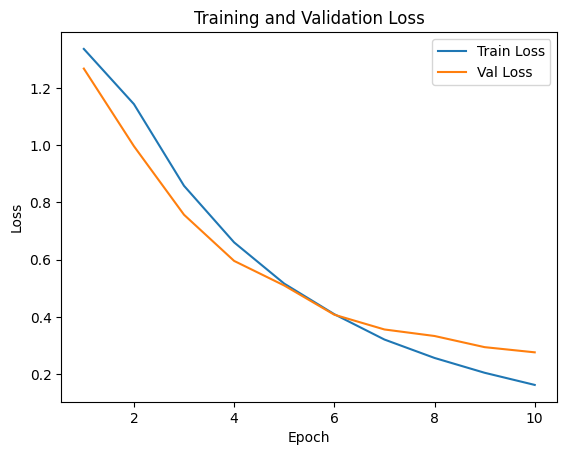

In [14]:
epochs = range(1, len(history['train_loss']) + 1)

plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [15]:
# Step 9: Evaluation
model.eval()
all_preds, all_labels = [], []
sample_texts = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        sample_texts.extend(tokenizer.batch_decode(input_ids, skip_special_tokens=True))

100%|██████████| 197/197 [00:04<00:00, 40.55it/s]


In [16]:
# Step 10: Print Report
label_map = {v: k for k, v in emotion_labels.items()}
print(classification_report(all_labels, all_preds, target_names=label_map.values()))

# Step 11: Show Sample Predictions
print("\n🎵 Sample Predictions:")
for i in range(5):
    print(f"\nLyrics: {sample_texts[i][:150]}...")
    print(f"Actual Emotion: {label_map[all_labels[i]]}")
    print(f"Predicted Emotion: {label_map[all_preds[i]]}")

              precision    recall  f1-score   support

       angry       0.86      0.94      0.90        99
       happy       0.91      0.91      0.91        99
     relaxed       0.94      0.87      0.90        98
         sad       0.89      0.88      0.88        97

    accuracy                           0.90       393
   macro avg       0.90      0.90      0.90       393
weighted avg       0.90      0.90      0.90       393


🎵 Sample Predictions:

Lyrics: it's a love thing, it's a love thing ( it's a love thing, thing ) the look in your eyes is more than enough to make my poor heart burst into flames be...
Actual Emotion: happy
Predicted Emotion: happy

Lyrics: lyrics from snippet but i still have one wish to make a special one for you merry christmas darling we're apart, thats true but i can dream and in my ...
Actual Emotion: happy
Predicted Emotion: happy

Lyrics: i'm really close tonight and i feel like i'm moving inside her lying in the dark and i think that i'm beginning t

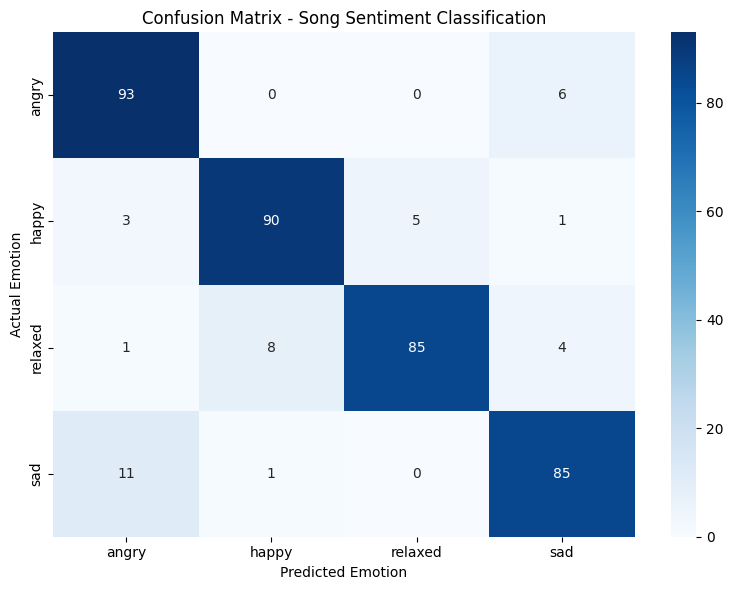

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
emotions = list(label_map.values())

# Plot it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.xlabel("Predicted Emotion")
plt.ylabel("Actual Emotion")
plt.title("Confusion Matrix - Song Sentiment Classification")
plt.tight_layout()
plt.show()


Recommendation system

In [18]:
def recommend_songs(df, predicted_emotion, top_k=5):
    recommendations = df[df["emotion"] == predicted_emotion].sample(n=top_k)

    print(f"\n💡 Based on your feeling, we think you're feeling: **{predicted_emotion.upper()}**\n")
    print(f"🎵 Recommended {predicted_emotion.title()} Songs for You:\n")

    for i, row in recommendations.iterrows():
        lyrics_snippet = row['cleaned_lyrics'][:100].replace("\n", " ") + "..."  # Display first 100 characters
        print(f"- 🎶 \"{lyrics_snippet}\"")

In [20]:
# Simulate user feeling input
user_input = "I feel like singing to my heart's content"

# Tokenize and move to device
inputs = tokenizer(user_input, return_tensors="pt", truncation=True, padding=True).to(device)

# Predict emotion using the trained model
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()

# Map predicted label to emotion string
label_to_emotion = {0: "angry", 1: "happy", 2: "relaxed", 3: "sad"}
predicted_emotion = label_to_emotion[predicted_label]

print(f"\n💡 Based on your feeling, we think you're feeling: **{predicted_emotion.upper()}**\n")

# Recommend songs based on predicted emotion
recommend_songs(df, predicted_emotion)


💡 Based on your feeling, we think you're feeling: **HAPPY**


💡 Based on your feeling, we think you're feeling: **HAPPY**

🎵 Recommended Happy Songs for You:

- 🎶 "If I should stay I would only be in your way So I'll go, but I know I'll think of you each step of t..."
- 🎶 "You're the kind When you love you love with all your might And you're the kind I would dream about a..."
- 🎶 "What makes them walk away, after all these years? These years of learning in the hard way By the les..."
- 🎶 "No fun, my babe No fun No fun, my babe No fun  No fun to hang around Feelin' that same old way No fu..."
- 🎶 "Fame (Fame) makes a man take things over Fame (Fame) lets him loose, hard to swallow Fame (Fame) put..."
